<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/lauri/pytorch-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# **Links**

* https://github.com/CoolCodeMan/intro2LT/blob/lauri/tfidf-bow-ja-linearSVC.ipynb
* https://github.com/graykode/nlp-tutorial
* https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/1-1.NNLM/NNLM.ipynb
* https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#sphx-glr-beginner-nlp-word-embeddings-tutorial-py
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding
* https://stackoverflow.com/questions/50747947/embedding-in-pytorch

# Download data

In [2]:
!wget -q -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -q -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -q -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

!wget -q -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -q -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -q -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv

# import python libraries

- numpy
- pandas
- pytorch
- scikit
- matplotlib

In [398]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from scipy.sparse import *
import sklearn.utils
import matplotlib.pyplot as plt

# Set up functions

- **shuffle** shuffles pandas dataframe
- **make_labels** takes in pandas dataframe and transforms it into tensor
- **create_dataset** takes anger and joy files, opens them into pandas dataframe and changing labels not-joy and not-anger into neutral
- **create_dataset_and_testset** takes in pandas dataframes and tranforms them into pytorch tensor
- **score** takes in model and tensors, scoring them
- **torch_shuffle** -- incomplete

In [399]:
def shuffle(data):
  data = sklearn.utils.shuffle(data)
  data.reset_index(inplace=True, drop=True)
  return data

In [400]:
def make_labels(labels):
  y = []
  for i in labels:
    if i == 'joy':
      y.append([1,0,0])
    elif i == 'anger':
      y.append([0,1,0])
    elif i == 'neutral':
      y.append([0,0,1])
  y = torch.tensor(y).float()
  return y

In [401]:
def create_dataset(angerpath, joypath):
  anger = pd.read_csv(angerpath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
  joy= pd.read_csv(joypath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')

  df = pd.concat([joy, anger])
  df['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
  df = shuffle(df)

  return df

In [402]:
def create_dataset_and_testset(pandas_dataset, vectorizer):

  feature_matrix = vectorizer.transform(pandas_dataset['text'])
  mat = feature_matrix.astype('float').toarray()
  X = torch.from_numpy(mat)
  y = make_labels(pandas_dataset['emotion'])

  return X, y

In [403]:
def score(model, dataset, labels, dataset_size=2024):
  total = 0
  for i in range(dataset_size):
    pred = model(dataset[i].float())
    n1 = pred.detach().cpu().numpy().argmax()
    n2 = labels[i].detach().cpu().numpy().argmax()
    if n2 == n1:
      total += 1
    
  return total/dataset_size*100

In [404]:
def torch_shuffle(t):
  idx = torch.randperm(t.shape[0])
  t = t[idx].view(t.size())
  return t

# Initialize data

In [405]:
dataset = create_dataset('/content/anger-train.tsv', '/content/joy-train.tsv')
vectorizer=CountVectorizer(analyzer='word', ngram_range=(1,1))
vectorizer.fit(dataset['text'])
dataset_train, labels_train = create_dataset_and_testset(dataset, vectorizer)

In [406]:
dataframe_dev = create_dataset('/content/anger-dev.tsv', '/content/joy-dev.tsv')
dataset_dev, labels_dev = create_dataset_and_testset(dataframe_dev, vectorizer)

In [407]:
dataframe_test = create_dataset('/content/anger-test.tsv', '/content/joy-test.tsv')
dataset_test, labels_test = create_dataset_and_testset(dataframe_test, vectorizer)

# Setup pytorch device

In [408]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [414]:
dataset_train = dataset_train.to(device)
labels_train = labels_train.to(device)

dataset_dev = dataset_dev.to(device)
labels_dev = labels_dev.to(device)

dataset_test = dataset_test.to(device)
labels_test = labels_test.to(device)

# Init neural network

In [415]:
class Net(nn.Module):
  def __init__(self, size):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(size, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self, X):

    out = self.fc1(X)
    out = torch.sigmoid(out)

    out = self.fc2(out)

    return out

# Setup neural network, loss function and optimizer

In [416]:
vocab_size = dataset_train.shape[1]

model = Net(vocab_size)
loss_function = nn.MSELoss(reduction='mean')
optimizer = optim.Adadelta(model.parameters(), eps=1e-5)

accuracy = []
losses = []

model = model.to(device)

# Train model

In [417]:
#@title Default title text
for epoch in range(20):
  print('epoch ', epoch)
  running_loss = 0.0
  # dataset_train = torch_shuffle(dataset_train)

  for i in range(2025):
    # model.zero_grad()
    
    optimizer.zero_grad()

    out = model(dataset_train[i].float())
    loss = loss_function(out, labels_train[i])

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # losses.append(running_loss)
    if i % 100 == 99:
        accuracy.append(score(model, dataset_train[:50], labels_train[:50], 50))
        losses.append(running_loss/100)
        running_loss = 0.0

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19


# SCORES

In [418]:
print('Train ', score(model, dataset_train, labels_train, dataset_size=2025))
print('Devel ', score(model, dataset_dev, labels_dev, dataframe_dev.shape[0]))
print('Test ', score(model, dataset_test, labels_test, dataframe_test.shape[0]))

Train  98.76543209876543
Devel  78.66666666666666
Test  79.3918918918919


# Statistics

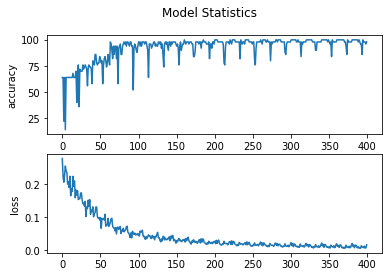

In [430]:
# %matplotlib inline
#%pylab inline
# import matplotlib.pyplot as plt

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1)

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()